In [1]:
from scipy.fft import fft, ifft, fftfreq, fftshift
import numpy as np
import matplotlib.pyplot as plt
import random as rn

# Monte-Carlo

In [543]:
def scattering(l_ph, g, thetha0, phi0, init):
    #прошедший путь до столкновения
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)

    #угол отклонения по оси z в новой СК
    r_th = rn.random()
    while r_th == 0 or r_th == 1:
        r_th = rn.random()
    #Хенья-Гринштейн
    th = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

    #угол отклонения в плоскости xy в новой СК
    phi = rn.uniform(0.0,1.0)*2*np.pi

    #углы отклонения в старой СК
    thetha0 = th + thetha0
    phi0 = phi + phi0

    #координаты столкновения в старой СК
    x1 = init[0] + length*np.sin(thetha0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(thetha0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(thetha0)

    return x1, y1, z1, thetha0, phi0, length

In [544]:
def layers(x1, y1, z1, length, L, n1, n2, th0, phi0, init, x, z, y):
    
    rt = rn.random()
    #длина пробега до линии разделения слоев
    l_before = length - (z1 - L)/np.cos(th0)
    
    #координаты в плоскости xy точки на линии разделения
    x_refl = init[0] + l_before*np.sin(th0)*np.cos(phi0)
    y_refl = init[1] + l_before*np.sin(th0)*np.sin(phi0)
    #запись точки в массив столкновений
    x.append(x_refl), y.append(y_refl), z.append(L)
    
    #условие на полное внутреннее отражение
    if abs(np.sin(th0)) <= n2/n1:
        #учет направления распространения
        sn = np.sign(np.cos(th0))
        if sn < 0:
            th_refr = np.pi - np.arcsin(n1*np.sin(th0)/n2)
        else:
            th_refr = np.arcsin(n1*np.sin(th0)/n2)

        #коэффициенты отражения
        r_s = (n1*np.cos(th0) - n2*np.cos(th_refr))/(n1*np.cos(th0) + n2*np.cos(th_refr))
        r_p = (n2*np.cos(th0) - n1*np.cos(th_refr))/(n2*np.cos(th0) + n1*np.cos(th_refr))
        refl = (abs(r_s)**2+abs(r_p)**2)/2
        
        if rt < refl:
            #отражение
            #угол отражения
            th0 = np.pi - th0
            #координаты до нового столкновения
            x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
            y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
            z1 = 2*L - z1
        else:
            #пропускание
            #угол преломления
            th0 = th_refr
            #координаты до нового столкновения
            x1 = x_refl + (length - l_before)*np.sin(th0)*np.cos(phi0)
            y1 = y_refl + (length - l_before)*np.sin(th0)*np.sin(phi0)
            z1 = L + (length - l_before)*np.cos(th0)


    else:
        #полное внутреннее отражение
        x1 = x_refl + (length-l_before)*np.cos(phi0)
        y1 = y_refl + (length - l_before)*np.sin(phi0)
        #учет направления распространения
        if x1 > x_refl:
            th0 = np.pi/2
        else:
            th0 = - np.pi/2
        z1 = L
        

    return x1, y1, z1, th0, phi0

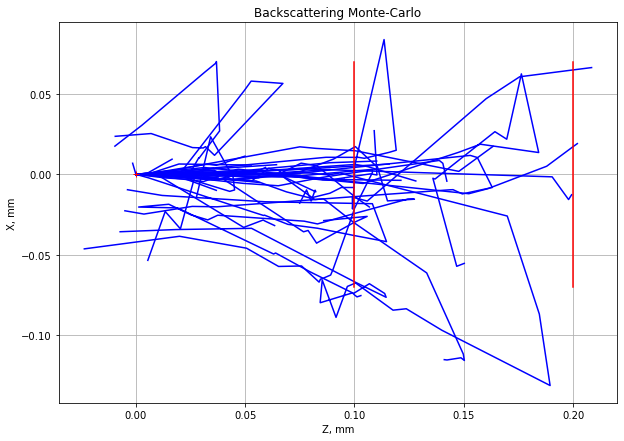

Обратно рассеяные 14.44 %


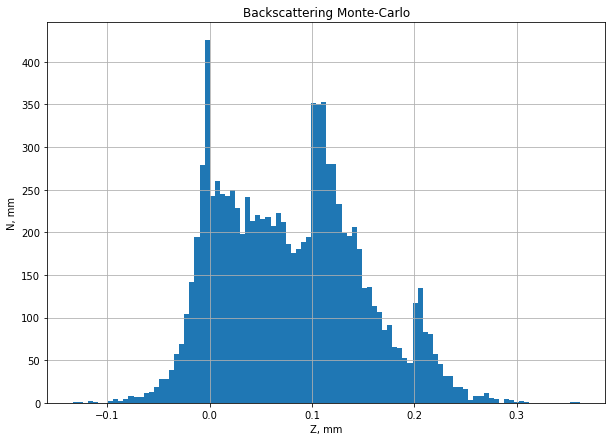

In [546]:
%matplotlib inline

#количество выводимых траекторий
graphs = 0
N_gr = 50

#показатеди преломдения сред
n1 = 1.4
n2 = 1.45
n3 = 1.47

#коэф абсорбции и рассеяния сред
mu_a = 4
mu_s = 42.5
mu_a1 = 7
mu_s1 = 30

#факторы анизотропии
g = 0.97
g1 = 0.85

#Ширины слоев
L = 0.1
L1 = 0.2

#Длина свободного пробега
l0 = 1/(mu_a + mu_s)
l01 = 1/(mu_a1 + mu_s1)

z_absorb = []
back = 0

#количество фотонов
N = 10000

#визуализация траекторий
fig, ax = plt.subplots(figsize =(10, 7))

for _ in range(N):
    #вероятность поглощения/рассеяния
    a = 0
    #начальная точка
    init = [0,0,0]
    #массивы коордитнат столкновений
    x, y, z = [0], [0], [0]
    #начальный угол распространения
    th0, phi0 = 0, 0
    
    #распространение в первом слое
    while a <= mu_s/(mu_a+mu_s) and  init[2] <= L:

        #пробег
        x1, y1, z1, th0, phi0, length = scattering(l0, g, th0, phi0, init)
        #проверка границы слоя
        if z1 > L:
            x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L, n1, n2, th0, phi0, init, x, z, y)
        
        x.append(x1), y.append(y1), z.append(z1)
        init = [x1,y1,z1]
        a = rn.random()
        
        #вылет из иследуемой области
        if z1 < 0:
            back = back + 1
            break
        
        #распространение во втором слое
        while a <= mu_s1/(mu_a1+mu_s1) and L < init[2] <= L1:

            #пробег
            x1, y1, z1, th0, phi0, length = scattering(l01, g1, th0, phi0, init)
            #проверка границы слоя
            if z1 > L1:
                x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L1, n2, n3, th0, phi0, init, x, z, y)
            elif z1 < L:
                x1, y1, z1, th0, phi0 = layers(x1, y1, z1, length, L, n2, n1, th0, phi0, init, x, z, y)
                
            x.append(x1), y.append(y1), z.append(z1)
            init = [x1,y1,z1]
            a = rn.random()
        
    #запись данных и вывод
    z_absorb.append(z[-1])
    if graphs < N_gr:
        plt.plot(z, x,'b')
        graphs = graphs + 1

#линии разделения слоев
f11 = [L, L]
f12 = [-0.07, 0.07]
f21 = [L1, L1]
f22 = f12

plt.plot(f11, f12, 'r')
plt.plot(f21, f22, 'r')
plt.plot(0,0, 'r+')
plt.grid()
plt.title('Backscattering Monte-Carlo')
plt.xlabel('Z, mm')
plt.ylabel('X, mm')
plt.show()

print('Обратно рассеяные', back/N*100, '%')

# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(z_absorb, bins = 100)
plt.grid()
plt.title('Backscattering Monte-Carlo')
plt.xlabel('Z, mm')
plt.ylabel('N, mm')
# Show plot
plt.show()

In [2]:
def initial(NA0, w0):
    #начальная точка
    x0, y0 = w0, w0
    while abs(x0) > w0/2:
        x0 = rn.gauss(0, w0)
    while abs(y0) > w0/2:    
        y0 = rn.gauss(0, w0)
    init = [x0, y0, 0]
    #начальное направление
    phi0 = rn.uniform(0.0, 1.0)*2*np.pi
    th0 =  rn.uniform(-NA0, NA0)
    return init, phi0, th0

In [200]:
def initial_and_first_scat(l_ph, NA0, w0):
    #начальная точка
    x0, y0 = w0, w0
    while abs(x0) > w0/2:
        x0 = rn.gauss(0, w0)
    while abs(y0) > w0/2:    
        y0 = rn.gauss(0, w0)
    init = [x0, y0, 0]
    #начальное направление
    phi0 = rn.uniform(0.0, 1.0)*2*np.pi
    th0 =  rn.uniform(-NA0, NA0)
    #начальный путь
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)
    way = length
    
    #координаты первого столкновения в старой СК
    x1 = init[0] + length*np.sin(th0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(th0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(th0)
    
    return way, x1, y1, z1, th0, phi0, init

In [201]:
def check(NA1, w0, x, y, z, th0):
    flag = False
    if abs(np.cos(th0)) >= np.cos(NA1):
        alpha = abs(z[-1]/z[-2])
        x_plane = x[-2]+alpha*(x[-1]-x[-2])
        y_plane = y[-2]+alpha*(y[-1]-y[-2])
        if abs(x_plane) <= w0/2 and abs(y_plane) <= w0/2:
            flag = True
    return flag   

In [116]:
%%time
%matplotlib qt
n = [1, 1.35, 1.4, 1.45]
#линии разделения слоев
Layers = [0, 0.02, 0.5, 2]
#коэф рассеяния/поглощения
mu_a = [0, 4, 1.7, 10]
mu_s = [0.0001, 42.5, 17.5, 20]
#длина свободного пробега в слое
l_ph = [1/(mu_s[i]+mu_a[i]) for i in range(len(Layers))]
#фактор анизотропии
g = [0.9999, 0.85, 0.85, 0.7]

RT = [reflection, transmition]
#Ширина генерации
w0 = 0.15
#Аппертура генерации
NA0 = np.pi/60
sigma0 = 2*np.pi*(1-np.cos(NA0))
#Аппертура премника
NA1 = np.pi/60
sigma1 = 2*np.pi*(1-np.cos(NA1))
#рассеяние/поглощение
sc_x = []
sc_z = []
reflected, scattered = [], []
back = 0
#Количесвто фотонов
N = 10000000
#fig, ax = plt.subplots(figsize =(10, 7))
for _ in range(N):
    bonk = 0
    num = 1
    a = 0
    ways = 0
    init, phi0, th0 = initial(NA0, w0)
    x, y, z = [init[0]], [init[1]], [0]
#     sc_x.append(x[0]), sc_z.append(z[0])
    while a <= mu_s[num]/(mu_s[num]+mu_a[num]):
        x1, y1, z1, th0, phi0, length = scattering(num, l_ph[num], g[num], th0, phi0, init)
        if num == 0:
            break
        ways = ways + length
#         print(ways)
        delta = 0
        
        #проверка микро-отр/пропуск
        while num != check_num(z1, Layers):
            if num == 0:
                break
            #определение направления движения
            sn = int(np.sign(np.cos(th0)))
            #отражение-пропускание
            flag = check_R_or_T(num, th0, sn, n, Layers)
            #новые координаты на перепроверку микро-отр/пропуск
            num, length, x1, y1, z1, th0, phi0, init, x, y, z = RT[flag](num, z1, length, th0, phi0, n, Layers, init, x, y, z)
#             sc_x.append(init[0]), sc_z.append(init[2])
#            print(length)
            delta = length
            
        #сохранение данных в массив    
        bonk = bonk + 1
        
        if num == 0:
            if (init[0]**2+init[1]**2) <= w0**2/4 and abs(np.cos(th0)) >= np.cos(NA1):
                ways = ways - delta
                if bonk <= 2:
                    reflected.append(ways)
                    break
                else:
                    scattered.append(ways)
                    break
        else:
            a = rn.random()
            x.append(x1), y.append(y1), z.append(z1)
#             sc_x.append(x1), sc_z.append(z1)
            init = [x1, y1, z1]
    
#     plt.plot(z, x, 'b')
#     plt.plot(sc_z, sc_x, 'r+')
# plt.plot([-0.03, 0], [w0/2, w0/2], 'k')
# plt.plot([-0.03, 0], [-w0/2, -w0/2], 'k')
# for i in range(len(Layers)-1):
#     plt.plot([Layers[i], Layers[i]], [-0.4, 0.4], 'g')    
# plt.grid()
# plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(reflected, bins = 500)
plt.grid()
plt.title('Refl Monte-Carlo')
plt.xlabel('way, mm')
plt.ylabel('N, штук')
#plt.xlim([0, 0.35])
# Show plot
plt.show()

fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(scattered, bins = 500)
plt.grid()
plt.title('Scat Monte-Carlo')
plt.xlabel('way, mm')
plt.ylabel('N, штук')
#plt.xlim([0, 0.35])
# Show plot
plt.show()
print((len(scattered)+len(reflected))/N*100, '%')

0.71381 %
CPU times: total: 1h 16min 41s
Wall time: 1h 17min 38s


In [37]:
def scattering(num, l_ph, g, thetha0, phi0, init):
    #прошедший путь до столкновения
    r1 = rn.random()
    while r1 == 0 or r1 == 1:
        r1 = rn.random() 
    length = -l_ph*np.log(1-r1)

    #угол отклонения по оси z в новой СК
    r_th = rn.random()
    while r_th == 0 or r_th == 1:
        r_th = rn.random()
    #Хенья-Гринштейн
    th = np.arccos((1 + g**2 - ((1 - g**2)/(1-g+2*g*r_th))**2)/ 2/g)

    #угол отклонения в плоскости xy в новой СК
    phi = rn.uniform(0.0,1.0)*2*np.pi

    #углы отклонения в старой СК
    thetha0 = th + thetha0
    phi0 = phi + phi0

    #координаты столкновения в старой СК
    x1 = init[0] + length*np.sin(thetha0)*np.cos(phi0)
    y1 = init[1] + length*np.sin(thetha0)*np.sin(phi0)
    z1 = init[2] + length*np.cos(thetha0)

    return x1, y1, z1, thetha0, phi0, length

In [38]:
#определение слоя по Z координате
def check_num(z_in, Layers):
    for num in range(len(Layers)):
        if z_in < Layers[num]:
            break
    return num

In [5]:
#вероятность отражения-пропускания
def check_R_or_T(num, th_in, sn, n, Layers):
    
    #проверка на полное внутреенее отражение
    if abs(np.sin(th_in)) <= n[num+sn]/n[num]:
        #угол преломления
        if sn < 0:
            th_refr = np.pi - np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
        else:
            th_refr = np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
            
        cos_in = abs(np.cos(th_in))
        cos_out = abs(np.cos(th_refr))
                        
        r_s = (n[num]*cos_in - n[num+sn]*cos_out)/(n[num]*cos_in + n[num+sn]*cos_out)
        r_p = (n[num+sn]*cos_in - n[num]*cos_out)/(n[num+sn]*cos_in + n[num]*cos_out)
        R_coef = (abs(r_s)**2+abs(r_p)**2)/2
        
        if rn.random() <= R_coef:
            return 0
        else:
            return 1
    else:
        return 0

In [6]:
def reflection(num, z_in, length, th_in, phi_in, n, Layers, init_xyz, x, y, z):
    
    #учет направления движения
    sn = np.sign(np.cos(th_in))
    
    #длина пробега до линии разделения слоев
    length_before = length - abs((z_in - Layers[num+int((sn-1)/2)])/np.cos(th_in)) #   num+(sn-1)/2 - учет линии между слоями 
    
    #координаты в плоскости xy точки на линии разделения
    x_plane = init_xyz[0] + length_before*np.sin(th_in)*np.cos(phi_in)
    y_plane = init_xyz[1] + length_before*np.sin(th_in)*np.sin(phi_in)
    
    #запись точки в массив столкновений
    x.append(x_plane), y.append(y_plane), z.append(Layers[num+int((sn-1)/2)])
    
    #угол отражения
    th_out = np.pi - th_in
    
    #новые начальные координаты
    init_xyz = [x_plane, y_plane, Layers[num+int((sn-1)/2)]]
    
    #координаты  до нового столкновения
    z_out = Layers[num+int((sn-1)/2)] - (length - length_before)*np.cos(th_in)
    x_out = x_plane + length*np.sin(th_in)*np.cos(phi_in)
    y_out = y_plane + length*np.sin(th_in)*np.sin(phi_in)
    
    
    return num, length - length_before, x_out, y_out, z_out, th_out, phi_in, init_xyz, x, y, z 

In [7]:
def transmition(num, z_in, length, th_in, phi_in, n, Layers, init_xyz, x, y, z):
    
    #учет направления движения
    sn = int(np.sign(np.cos(th_in)))
    #длина пробега до линии разделения слоев
    length_before = length - (z_in - Layers[num+int((sn-1)/2)])/np.cos(th_in) #   num+(sn-1)/2 - учет линии между слоями 
    #координаты в плоскости xy точки на линии разделения
    x_plane = init_xyz[0] + length_before*np.sin(th_in)*np.cos(phi_in)
    y_plane = init_xyz[1] + length_before*np.sin(th_in)*np.sin(phi_in)
    #запись точки в массив столкновений
    x.append(x_plane), y.append(y_plane), z.append(Layers[num+int((sn-1)/2)])

    #угол преломления
    if sn < 0:
        th_refractive = np.pi - np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
    else:
        th_refractive = np.arcsin(n[num]*np.sin(th_in)/n[num+sn])
        
    th_out = th_refractive
    
    #новые начальные координаты
    init_xyz = [x_plane, y_plane, Layers[num+int((sn-1)/2)]]
    
    #координаты до нового столкновения
    z_out = Layers[num+int((sn-1)/2)] + (length - length_before)*np.cos(th_out)
    x_out = x_plane + (length - length_before)*np.sin(th_out)*np.cos(phi_in)
    y_out = y_plane + (length - length_before)*np.sin(th_out)*np.sin(phi_in)
    
    
    return num+int(sn), length - length_before, x_out, y_out, z_out, th_out, phi_in, init_xyz, x, y, z 

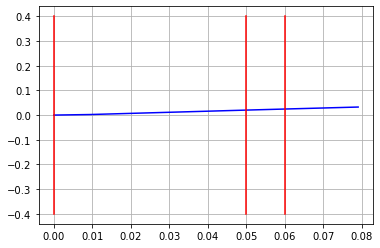

CPU times: total: 297 ms
Wall time: 297 ms


In [13]:
%%time
%matplotlib inline
#показатель преломления слоев
n = [1, 1.4, 1.43, 1.45]
#линии разделения слоев
Layers = [0, 0.05, 0.06, 2]
#коэф рассеяния/поглощения
mu_a = [0, 2, 5, 10]
mu_s = [0.0001, 60.5, 30, 20]
#длина свободного пробега в слое
l_ph = [1/(mu_s[i]+mu_a[i]) for i in range(len(Layers))]
#фактор анизотропии
g = [0.9999, 0.9, 0.8, 0.7]
back = 0
RT = [reflection, transmition]
#число фотонов
N = 1
for i in range(N):
    num = 1
    a = 0
    init = [0, 0, 0]
    th0, phi0 = 0, 0
    x, y, z = [0], [0], [0]
    while a <= mu_s[num]/(mu_s[num]+mu_a[num]):
        x1, y1, z1, th0, phi0, length = scattering(num, l_ph[num], g[num], th0, phi0, init)
        if num == 0:
            back = back+1
            break
        
        #проверка микро-отр/пропуск
        while num != check_num(z1, Layers):
            if num == 0:
                break
            #определение направления движения
            sn = int(np.sign(np.cos(th0)))
            #отражение-пропускание
            flag = check_R_or_T(num, th0, sn, n, Layers)
            #новые координаты на перепроверку микро-отр/пропуск
            num, length, x1, y1, z1, th0, phi0, init, x, y, z = RT[flag](num, z1, length, th0, phi0, n, Layers, init, x, y, z)
            
        #сохранение данных в массив    
        x.append(x1), y.append(y1), z.append(z1)
        init = [x1, y1, z1]
        a = rn.random()
        
    plt.plot(z, x, 'b')
    
for i in range(len(Layers)-1):
    plt.plot([Layers[i], Layers[i]], [-0.4, 0.4], 'r')
plt.grid()
plt.show()            
#print(back/N*100, '%')        
        